In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_curve, auc
import itertools
import json

# Setup

In [2]:
pred_prefix = "../ss/iWildCam_"
target_prefix = "../ss/target_iWildCam_"
unc_out_prefix = "ss/unc_"
pred_out_prefix = "ss/pred_"
num_classes = 182
test_sets=["ind","ood"]

S_model_ls = ["Resnet18ft0", "Resnet18ft1", "Resnet18ft2", "Resnet18ft3", "Resnet18ft4"]
M_model_ls = ["Resnet50ft0","Resnet50ft2"]
L_model_ls = ["Resnet101ft0","Resnet101ft1"]
M_lp_ls = ["Resnet50lp0","Resnet50lp2"]
L_lp_ls = ["Resnet101lp0","Resnet101lp1"]

## Create Ensemble as Baseline:

In [3]:
# Function to load predictions
def load_predictions(prefix, testtype, models):
    return [pd.read_csv(f"{prefix}{testtype}_{model}.csv") for model in models]

# Function to save ensemble predictions
def save_ensemble_predictions(prefix, testtype, name, predictions):
    predictions.to_csv(f"{prefix}{testtype}_{name}.csv", index=False)

# Function to generate ensemble name
def generate_ensemble_name(base_name, models):
    return f"{base_name}_{'_'.join(models)}"

# Initialize categories dictionary
categories = {
    "S": S_model_ls,
    "M": M_model_ls,
    "L": L_model_ls,
    "Mlp": M_lp_ls,
    "Llp": L_lp_ls
}
categories.update({f"EnsM={m}": [] for m in range(2, len(S_model_ls) + 1)})
categories.update({
    "SM_duo": [],
    "SL_duo": [],
    "lpft_M": [],
    "lpft_L": []
})

for testtype in test_sets:
    print(f"Working on {testtype}:")
    # Load raw predictions
    S_predictions = load_predictions(pred_prefix, testtype, S_model_ls)
    M_predictions = load_predictions(pred_prefix, testtype, M_model_ls)
    L_predictions = load_predictions(pred_prefix, testtype, L_model_ls)
    M_lp_predictions = load_predictions(pred_prefix, testtype, M_lp_ls)
    L_lp_predictions = load_predictions(pred_prefix, testtype, L_lp_ls)
    
    print("Generating ensembles from S models")
    for m in range(2, len(S_model_ls)+1):
        ensemble_index = 1
        print(f"{m=}...")
        for comb in itertools.combinations(S_model_ls, m):
            ensemble_pred = utils.softvote([pd.read_csv(f"{pred_prefix}{testtype}_{model}.csv") for model in comb])
            ensemble_name = generate_ensemble_name(f"EnsS_{m}", comb)
            save_ensemble_predictions(pred_prefix, testtype, ensemble_name, ensemble_pred)
            if testtype==test_sets[0]: 
                categories[f"EnsM={m}"].append(ensemble_name)
            ensemble_index += 1

    print("Generating SM duos and SL duos")
    for s_model in S_model_ls:
        for m_model in M_model_ls:
            sm_duo_pred = utils.softvote([pd.read_csv(f"{pred_prefix}{testtype}_{s_model}.csv"), pd.read_csv(f"{pred_prefix}{testtype}_{m_model}.csv")])
            sm_duo_name = generate_ensemble_name("SM_duo", [s_model, m_model])
            save_ensemble_predictions(pred_prefix, testtype, sm_duo_name, sm_duo_pred)
            if testtype == test_sets[0]:
                categories["SM_duo"].append(sm_duo_name)

        for l_model in L_model_ls:
            sl_duo_pred = utils.softvote([pd.read_csv(f"{pred_prefix}{testtype}_{s_model}.csv"), pd.read_csv(f"{pred_prefix}{testtype}_{l_model}.csv")])
            sl_duo_name = generate_ensemble_name("SL_duo", [s_model, l_model])
            save_ensemble_predictions(pred_prefix, testtype, sl_duo_name, sl_duo_pred)
            if testtype == test_sets[0]:
                categories["SL_duo"].append(sl_duo_name)

    print("Generating lpft-M duos")
    for m_ft, m_lp in zip(M_model_ls, M_lp_ls):
        lpft_m_pred = utils.softvote([pd.read_csv(f"{pred_prefix}{testtype}_{m_lp}.csv"), pd.read_csv(f"{pred_prefix}{testtype}_{m_ft}.csv")])
        lpft_m_name = generate_ensemble_name("lpft_M", [m_ft, m_lp])
        save_ensemble_predictions(pred_prefix, testtype, lpft_m_name, lpft_m_pred)
        if testtype == test_sets[0]:
            categories["lpft_M"].append(lpft_m_name)

    print("Generating lpft-L duos")
    for l_ft, l_lp in zip(L_model_ls, L_lp_ls):
        lpft_l_pred = utils.softvote([pd.read_csv(f"{pred_prefix}{testtype}_{l_lp}.csv"), pd.read_csv(f"{pred_prefix}{testtype}_{l_ft}.csv")])
        lpft_l_name = generate_ensemble_name("lpft_L", [l_ft, l_lp])
        save_ensemble_predictions(pred_prefix, testtype, lpft_l_name, lpft_l_pred)
        if testtype == test_sets[0]:
            categories["lpft_L"].append(lpft_l_name)

# Save the categories dictionary for use in the evaluation script
with open(f"{pred_out_prefix}categories.json", "w") as file:
    json.dump(categories, file)

Working on ind:
Generating ensembles from S models
m=2...
m=3...
m=4...
m=5...
Generating SM duos and SL duos
Generating lpft-M duos
Generating lpft-L duos
Working on ood:
Generating ensembles from S models
m=2...
m=3...
m=4...
m=5...
Generating SM duos and SL duos
Generating lpft-M duos
Generating lpft-L duos


## {F1, Acc, Brier, Ece, Mce} of raw models 

In [4]:

# Load the categories dictionary
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)

# Function to evaluate models and store metrics
def evaluate_models(predictions, label, prefix, testtype, metrics_dict, category):
    for method in predictions:
        pred_col_name = f"pred_{method}"
        pred = pd.read_csv(f"{prefix}{testtype}_{method}.csv")
        label[pred_col_name] = pred.idxmax(axis=1)
        label[pred_col_name] = label[pred_col_name].str.extract('(\d+)').astype(int)
        
        curr_f1 = f1_score(label["target"], label[pred_col_name], average='macro')
        curr_brier = utils.brier_score(utils.one_hot(np.array(label["target"]), num_classes), utils.softmax(pred))
        curr_ece, curr_mce = utils.calibration(utils.one_hot(np.array(label["target"]), num_classes), utils.softmax(pred))
        
        # Store metrics
        metrics_dict["Model"].append(method)
        metrics_dict["Test Set"].append(testtype)
        metrics_dict["F1"].append(curr_f1)
        metrics_dict["Brier"].append(curr_brier)
        metrics_dict["ECE"].append(curr_ece)
        metrics_dict["MCE"].append(curr_mce)
        metrics_dict["Category"].append(category)
    return metrics_dict

metrics_dict = {
    "Model": [],
    "Test Set": [],
    "F1": [],
    "Brier": [],
    "ECE": [],
    "MCE": [],
    "Category": []
}

for testtype in test_sets:
    print(f"Evaluating on {testtype}:")
    label = pd.read_csv(f"{target_prefix}{testtype}.csv")
    
    for category, models in categories.items():
        metrics_dict = evaluate_models(models, label, pred_prefix, testtype, metrics_dict, category)

metrics_df = pd.DataFrame(metrics_dict)
display(metrics_df)
metrics_df.to_csv(f"{pred_out_prefix}metrics.csv", index=False)


Evaluating on ind:
Evaluating on ood:


,Model,Test Set,F1,Brier,ECE,MCE,Category
0,Resnet18ft0,ind,0.404493,0.002178,0.155458,0.803209,S
1,Resnet18ft1,ind,0.389290,0.002121,0.149154,0.335268,S
2,Resnet18ft2,ind,0.413737,0.002062,0.139432,0.317058,S
3,Resnet18ft3,ind,0.399845,0.002130,0.150373,0.319380,S
4,Resnet18ft4,ind,0.419727,0.002055,0.144228,0.321982,S
...,...,...,...,...,...,...,...
117,SL_duo_Resnet18ft4_Resnet101ft0,ood,0.327109,0.002413,0.155260,0.452917,SL_duo
118,SL_duo_Resnet18ft4_Resnet101ft1,ood,0.335264,0.002512,0.171570,0.478001,SL_duo
119,lpft_M_Resnet50ft0_Resnet50lp3,ood,0.322173,0.002125,0.098685,0.305680,lpft_M
120,lpft_M_Resnet50ft2_Resnet50lp2,ood,0.319613,0.002357,0.132229,0.338873,lpft_M


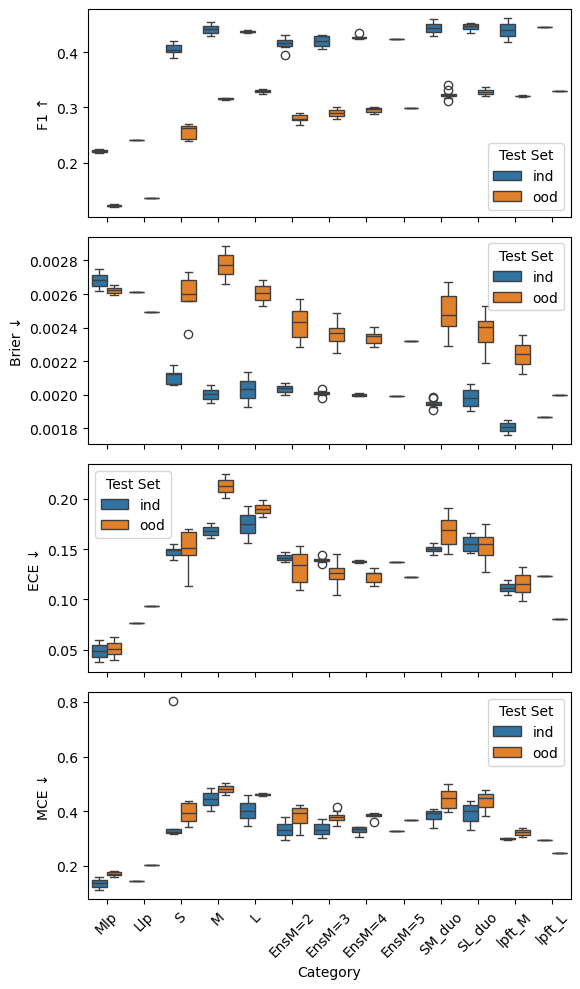

In [5]:
# Plot the metrics
category_order = ["Mlp", "Llp", "S", "M", "L"] + [f"EnsM={m}" for m in range(2, len(S_model_ls) + 1)] + ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]

plt.figure(figsize=(6, 10))
metrics = ['F1', 'Brier', 'ECE', 'MCE']
arrows = ["↑","↓","↓","↓"]
for i, metric in enumerate(metrics):
    plt.subplot(4, 1, i + 1)
    sns.boxplot(data=metrics_df, x='Category', y=metric, hue='Test Set', order=category_order)
    plt.ylabel(metric + " " + arrows[i])
    if i < len(metrics) - 1:
        plt.xlabel('')  # Remove x-label for all plots except the last one
        plt.tick_params(labelbottom=False)  # Hide x-ticks and x-tick labels
    else:
        plt.xlabel('Category')  # Set x-label for the last plot
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Load the categories dictionary
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)

# Generate the uncertainty DataFrame
for testtype in test_sets:
    print(f"Generating uncertainty DataFrame for {testtype}...")
    unc = pd.DataFrame()
    
    # Calculate entropy for all models
    print(f"Calculating entropy for all models")
    for category, models in categories.items():
        for model in models:
            predictions = pd.read_csv(f"{pred_prefix}{testtype}_{model}.csv")
            unc[f"entr_{model}"] = utils.calc_entr_torch(predictions)
    
    # Calculate cross-entropy for specific pairs
    print(f"Calculating cross-entropy(M||S)")
    for s_model in S_model_ls:
        for m_model in M_model_ls:
            m_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{m_model}.csv")
            s_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{s_model}.csv")
            unc[f"ce_{m_model}_{s_model}"] = utils.calc_cross_entr_torch(m_predictions, s_predictions)
            unc[f"entr_{m_model}+ce_{m_model}_{s_model}"] = unc[f"entr_{m_model}"] + unc[f"ce_{m_model}_{s_model}"]

    print(f"Calculating cross-entropy(L||S)")
    for s_model in S_model_ls:
        for l_model in L_model_ls:
            l_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{l_model}.csv")
            s_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{s_model}.csv")
            unc[f"ce_{l_model}_{s_model}"] = utils.calc_cross_entr_torch(l_predictions, s_predictions)
            unc[f"entr_{l_model}+ce_{l_model}_{s_model}"] = unc[f"entr_{l_model}"] + unc[f"ce_{l_model}_{s_model}"]

    print(f"Calculating cross-entropy(Mft||Mlp)")
    for m_ft, m_lp in zip(M_model_ls, M_lp_ls):
        m_ft_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{m_ft}.csv")
        m_lp_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{m_lp}.csv")
        unc[f"ce_{m_ft}_{m_lp}"] = utils.calc_cross_entr_torch(m_ft_predictions, m_lp_predictions)
        unc[f"entr_{m_ft}+ce_{m_ft}_{m_lp}"] = unc[f"entr_{m_ft}"] + unc[f"ce_{m_ft}_{m_lp}"]

    print(f"Calculating cross-entropy(Mft||Mlp)")
    for l_ft, l_lp in zip(L_model_ls, L_lp_ls):
        l_ft_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{l_ft}.csv")
        l_lp_predictions = pd.read_csv(f"{pred_prefix}{testtype}_{l_lp}.csv")
        unc[f"ce_{l_ft}_{l_lp}"] = utils.calc_cross_entr_torch(l_ft_predictions, l_lp_predictions)
        unc[f"entr_{l_ft}+ce_{l_ft}_{l_lp}"] = unc[f"entr_{l_ft}"] + unc[f"ce_{l_ft}_{l_lp}"]

    # Save the uncertainty DataFrame
    unc.to_csv(f"{unc_out_prefix}{testtype}.csv", index=False)
    print(f"Saved uncertainty DataFrame for {testtype}.")

Generating uncertainty DataFrame for ind...
Calculating entropy for all models
Calculating cross-entropy(M||S)
Calculating cross-entropy(L||S)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{l_model}+ce_{l_model}_{s_model}"] = unc[f"entr_{l_model}"] + unc[f"ce_{l_model}_{s_model}"]


Calculating cross-entropy(Mft||Mlp)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"ce_{m_ft}_{m_lp}"] = utils.calc_cross_entr_torch(m_ft_predictions, m_lp_predictions)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{m_ft}+ce_{m_ft}_{m_lp}"] = unc[f"entr_{m_ft}"] + unc[f"ce_{m_ft}_{m_lp}"]
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:38: PerformanceWarning:

Calculating cross-entropy(Mft||Mlp)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"ce_{l_ft}_{l_lp}"] = utils.calc_cross_entr_torch(l_ft_predictions, l_lp_predictions)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{l_ft}+ce_{l_ft}_{l_lp}"] = unc[f"entr_{l_ft}"] + unc[f"ce_{l_ft}_{l_lp}"]


Saved uncertainty DataFrame for ind.
Generating uncertainty DataFrame for ood...
Calculating entropy for all models
Calculating cross-entropy(M||S)
Calculating cross-entropy(L||S)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{l_model}+ce_{l_model}_{s_model}"] = unc[f"entr_{l_model}"] + unc[f"ce_{l_model}_{s_model}"]


Calculating cross-entropy(Mft||Mlp)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"ce_{m_ft}_{m_lp}"] = utils.calc_cross_entr_torch(m_ft_predictions, m_lp_predictions)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{m_ft}+ce_{m_ft}_{m_lp}"] = unc[f"entr_{m_ft}"] + unc[f"ce_{m_ft}_{m_lp}"]
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:38: PerformanceWarning:

Calculating cross-entropy(Mft||Mlp)


/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"ce_{l_ft}_{l_lp}"] = utils.calc_cross_entr_torch(l_ft_predictions, l_lp_predictions)
/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_6868/2092901788.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc[f"entr_{l_ft}+ce_{l_ft}_{l_lp}"] = unc[f"entr_{l_ft}"] + unc[f"ce_{l_ft}_{l_lp}"]


Saved uncertainty DataFrame for ood.


In [7]:
# Load the categories dictionary
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)

# Generate prediction DataFrame
for testtype in test_sets:
    print(f"Generating prediction DataFrame for {testtype}...")
    pred_df = pd.read_csv(f"{target_prefix}{testtype}.csv")

    for category, models in categories.items():
        for model in models:
            predictions = pd.read_csv(f"{pred_prefix}{testtype}_{model}.csv")
            pred_df[f"pred_{model}"] = predictions.idxmax(axis=1).str.extract('(\d+)')

    # Save the prediction DataFrame
    pred_df.to_csv(f"{pred_out_prefix}{testtype}.csv", index=False)
    print(f"Saved prediction DataFrame for {testtype}.")
    display(pred_df.head(3))

Generating prediction DataFrame for ind...
Saved prediction DataFrame for ind.


,target,pred_Resnet18ft0,pred_Resnet18ft1,pred_Resnet18ft2,pred_Resnet18ft3,pred_Resnet18ft4,pred_Resnet50ft0,pred_Resnet50ft2,pred_Resnet101ft0,pred_Resnet101ft1,...,pred_SL_duo_Resnet18ft1_Resnet101ft1,pred_SL_duo_Resnet18ft2_Resnet101ft0,pred_SL_duo_Resnet18ft2_Resnet101ft1,pred_SL_duo_Resnet18ft3_Resnet101ft0,pred_SL_duo_Resnet18ft3_Resnet101ft1,pred_SL_duo_Resnet18ft4_Resnet101ft0,pred_SL_duo_Resnet18ft4_Resnet101ft1,pred_lpft_M_Resnet50ft0_Resnet50lp3,pred_lpft_M_Resnet50ft2_Resnet50lp2,pred_lpft_L_Resnet101ft0_Resnet101lp2
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Generating prediction DataFrame for ood...
Saved prediction DataFrame for ood.


,target,pred_Resnet18ft0,pred_Resnet18ft1,pred_Resnet18ft2,pred_Resnet18ft3,pred_Resnet18ft4,pred_Resnet50ft0,pred_Resnet50ft2,pred_Resnet101ft0,pred_Resnet101ft1,...,pred_SL_duo_Resnet18ft1_Resnet101ft1,pred_SL_duo_Resnet18ft2_Resnet101ft0,pred_SL_duo_Resnet18ft2_Resnet101ft1,pred_SL_duo_Resnet18ft3_Resnet101ft0,pred_SL_duo_Resnet18ft3_Resnet101ft1,pred_SL_duo_Resnet18ft4_Resnet101ft0,pred_SL_duo_Resnet18ft4_Resnet101ft1,pred_lpft_M_Resnet50ft0_Resnet50lp3,pred_lpft_M_Resnet50ft2_Resnet50lp2,pred_lpft_L_Resnet101ft0_Resnet101lp2
0,113,0,0,0,0,0,68,113,113,0,...,0,0,0,0,0,0,0,68,113,113
1,113,0,0,0,0,0,68,68,113,68,...,0,0,68,0,68,0,68,68,68,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Accuracy Prediction AUROC

In [8]:
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)
    
# Initialize the AUROC results dictionary
auroc_results = {
    "Category": [],
    "Model": [],
    "Test Set": [],
    "AUROC Entr Mean": [],
    "AUROC Entr+CE Mean": []
}

# Function to calculate AUROC
def calculate_auroc(pred_df, unc_df, pred_vec, target_vec, unc_vec):
    if isinstance(pred_df[pred_vec].iloc[0], str):
        is_correct = pred_df.apply(lambda row: str(row[target_vec]) not in row[pred_vec], axis=1)
    else:
        is_correct = pred_df[pred_vec] != pred_df[target_vec]
    fpr, tpr, threshold = roc_curve(is_correct, unc_df[unc_vec])
    roc_auc = auc(fpr, tpr)
    return roc_auc

for testtype in test_sets:
    print(f"Evaluating AUROC for {testtype}...")
    pred_df = pd.read_csv(f"{pred_out_prefix}{testtype}.csv")
    unc_df = pd.read_csv(f"{unc_out_prefix}{testtype}.csv")

    for category, models in categories.items():
        for model in models:
            pred_column = f"pred_{model}"
            entr_column = f"entr_{model}"

            if pred_column in pred_df.columns and entr_column in unc_df.columns:
                auroc_value = calculate_auroc(pred_df, unc_df, pred_column, "target", entr_column)

                # Add AUROC values to the results dictionary
                auroc_results["Category"].append(category)
                auroc_results["Model"].append(model)
                auroc_results["Test Set"].append(testtype)
                auroc_results["AUROC Entr Mean"].append(auroc_value)
                auroc_results["AUROC Entr+CE Mean"].append(None)

                if category in ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]:
                    model_ls = model.split('_')[2:]
                    ce_column = f"entr_{model_ls[1]}+ce_{model_ls[1]}_{model_ls[0]}" if category in ["SM_duo", "SL_duo"] else f"entr_{model_ls[0]}+ce_{model_ls[0]}_{model_ls[1]}"

                    if ce_column in unc_df.columns:
                        combined_auroc_value = calculate_auroc(pred_df, unc_df, pred_column, "target", ce_column)
                        auroc_results["AUROC Entr+CE Mean"][-1] = combined_auroc_value
                    else:
                        print(ce_column)
                        print(unc_df.columns)

# Convert the results dictionary to a DataFrame
auroc_df = pd.DataFrame(auroc_results)
display(auroc_df)

# Save the AUROC results to a CSV file
auroc_df.to_csv(f"{unc_out_prefix}auroc_results.csv", index=False)

Evaluating AUROC for ind...
Evaluating AUROC for ood...


,Category,Model,Test Set,AUROC Entr Mean,AUROC Entr+CE Mean
0,S,Resnet18ft0,ind,0.851489,NaN
1,S,Resnet18ft1,ind,0.883082,NaN
2,S,Resnet18ft2,ind,0.874906,NaN
3,S,Resnet18ft3,ind,0.862662,NaN
4,S,Resnet18ft4,ind,0.873154,NaN
...,...,...,...,...,...
117,SL_duo,SL_duo_Resnet18ft4_Resnet101ft0,ood,0.911536,0.900962
118,SL_duo,SL_duo_Resnet18ft4_Resnet101ft1,ood,0.916734,0.901200
119,lpft_M,lpft_M_Resnet50ft0_Resnet50lp3,ood,0.900555,0.904168
120,lpft_M,lpft_M_Resnet50ft2_Resnet50lp2,ood,0.909368,0.922903


In [9]:
# Load the categories dictionary
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)

# Initialize the F1-Coverage tradeoff results dictionary
f1_cov_results = {
    "Category": [],
    "Model": [],
    "Test Set": [],
    "F1-Cov AUC Entr Mean": [],
    "F1-Cov AUC Entr+CE Mean": []
}

def calculate_f1_cov_auc(pred_df, unc_df, pred_vec, target_vec, unc_vec, cov_range):
    rank = utils.get_rank(unc_df)
    temp = pd.DataFrame()
    temp["coverage"] = cov_range
    coverage_ls = (cov_range + 1) / 100 * pred_df.shape[0]
    for i, cov in enumerate(coverage_ls):
        cov_pred = pred_df.loc[rank[unc_vec] < cov]
        temp.loc[i, "f1"] = f1_score(cov_pred[target_vec], cov_pred[pred_vec], average='macro')
    area = np.sum(temp["f1"])
    return area

cov_range = np.arange(19, 100)

for testtype in test_sets:
    print(f"Evaluating F1-Coverage tradeoff AUC for {testtype}...")
    pred_df = pd.read_csv(f"{pred_out_prefix}{testtype}.csv")
    unc_df = pd.read_csv(f"{unc_out_prefix}{testtype}.csv")

    for category, models in categories.items():
        print(f"{category=}")
        for model in models:
            if category in ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]:
                model_ls = model.split('_')[2:]
                pred_column = f"pred_{model_ls[1]}" if category in ["SM_duo", "SL_duo"] else f"pred_{model_ls[0]}"
                entr_column = f"entr_{model_ls[1]}" if category in ["SM_duo", "SL_duo"] else f"entr_{model_ls[0]}"
            else:
                pred_column = f"pred_{model}"
                entr_column = f"entr_{model}"
            if pred_column in pred_df.columns and entr_column in unc_df.columns:
                f1_cov_auc_value = calculate_f1_cov_auc(pred_df, unc_df, pred_column, "target", entr_column, cov_range)

                # Add F1-Coverage AUC values to the results dictionary
                f1_cov_results["Category"].append(category)
                f1_cov_results["Model"].append(model)
                f1_cov_results["Test Set"].append(testtype)
                f1_cov_results["F1-Cov AUC Entr Mean"].append(f1_cov_auc_value)
                f1_cov_results["F1-Cov AUC Entr+CE Mean"].append(None)

                if category in ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]:
                    model_ls = model.split('_')[2:]
                    ce_column = f"entr_{model_ls[1]}+ce_{model_ls[1]}_{model_ls[0]}" if category in ["SM_duo", "SL_duo"] else f"entr_{model_ls[0]}+ce_{model_ls[0]}_{model_ls[1]}"

                    if ce_column in unc_df.columns:
                        combined_f1_cov_auc_value = calculate_f1_cov_auc(pred_df, unc_df, pred_column, "target", ce_column, cov_range)
                        f1_cov_results["F1-Cov AUC Entr+CE Mean"][-1] = combined_f1_cov_auc_value
                    else:
                        print(ce_column)
                        print(unc_df.columns)

# Convert the results dictionary to a DataFrame
f1_cov_df = pd.DataFrame(f1_cov_results)
display(f1_cov_df)

# Save the F1-Coverage AUC results to a CSV file
f1_cov_df.to_csv(f"{unc_out_prefix}f1_cov_auc_results.csv", index=False)

Evaluating F1-Coverage tradeoff AUC for ind...
category='S'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='M'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='L'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='Mlp'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='Llp'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=2'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=3'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=4'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=5'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='SM_duo'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='SL_duo'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='lpft_M'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='lpft_L'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Evaluating F1-Coverage tradeoff AUC for ood...
category='S'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='M'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='L'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='Mlp'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='Llp'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=2'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=3'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=4'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='EnsM=5'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='SM_duo'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='SL_duo'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='lpft_M'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

category='lpft_L'


/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rank[curr_metric] = unc_pred[curr_metric].rank()
/Users/timothyzhou/Code/research/wliura2024/Analysis/utils.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

,Category,Model,Test Set,F1-Cov AUC Entr Mean,F1-Cov AUC Entr+CE Mean
0,S,Resnet18ft0,ind,55.290630,NaN
1,S,Resnet18ft1,ind,55.322073,NaN
2,S,Resnet18ft2,ind,55.357192,NaN
3,S,Resnet18ft3,ind,54.065846,NaN
4,S,Resnet18ft4,ind,56.240043,NaN
...,...,...,...,...,...
117,SL_duo,SL_duo_Resnet18ft4_Resnet101ft0,ood,47.834405,48.804772
118,SL_duo,SL_duo_Resnet18ft4_Resnet101ft1,ood,49.298860,49.112835
119,lpft_M,lpft_M_Resnet50ft0_Resnet50lp3,ood,47.726169,39.317847
120,lpft_M,lpft_M_Resnet50ft2_Resnet50lp2,ood,48.410574,40.487913


In [10]:
# Load the categories dictionary
with open(f"{pred_out_prefix}categories.json", "r") as file:
    categories = json.load(file)

# Initialize the AUROC OOD results dictionary
auroc_ood_results = {
    "Category": [],
    "Model": [],
    "Test Set": [],
    "AUROC OOD Entr Mean": [],
    "AUROC OOD Entr+CE Mean": []
}

def calculate_auroc_ood(pred_df, unc_df, pred_vec, unc_vec):
    is_ood = np.where(pred_df["test_type"].isin(["ood"]), True, False)
    fpr, tpr, threshold = roc_curve(is_ood, unc_df[unc_vec])
    roc_auc = auc(fpr, tpr)
    return roc_auc

# Combine in-distribution and out-of-distribution data
pred_df_ind = pd.read_csv(f"{pred_out_prefix}ind.csv")
unc_df_ind = pd.read_csv(f"{unc_out_prefix}ind.csv")
pred_df_ood = pd.read_csv(f"{pred_out_prefix}ood.csv")
unc_df_ood = pd.read_csv(f"{unc_out_prefix}ood.csv")

pred_df_ind["test_type"] = "ind"
pred_df_ood["test_type"] = "ood"

pred_df_combined = pd.concat([pred_df_ood, pred_df_ind], ignore_index=True)
unc_df_combined = pd.concat([unc_df_ood, unc_df_ind], ignore_index=True)

# Calculate AUROC for OOD detection
for category, models in categories.items():
    for model in models:
        if category in ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]:
            model_ls = model.split('_')[2:]
            pred_column = f"pred_{model_ls[1]}" if category in ["SM_duo", "SL_duo"] else f"pred_{model_ls[0]}"
            entr_column = f"entr_{model_ls[1]}" if category in ["SM_duo", "SL_duo"] else f"entr_{model_ls[0]}"
        else:
            pred_column = f"pred_{model}"
            entr_column = f"entr_{model}"
        if pred_column in pred_df_combined.columns and entr_column in unc_df_combined.columns:
            auroc_ood_value = calculate_auroc_ood(pred_df_combined, unc_df_combined, pred_column, entr_column)

            # Add AUROC OOD values to the results dictionary
            auroc_ood_results["Category"].append(category)
            auroc_ood_results["Model"].append(model)
            auroc_ood_results["Test Set"].append("combined")
            auroc_ood_results["AUROC OOD Entr Mean"].append(auroc_ood_value)
            auroc_ood_results["AUROC OOD Entr+CE Mean"].append(None)

            if category in ["SM_duo", "SL_duo", "lpft_M", "lpft_L"]:
                ce_column = f"entr_{model_ls[1]}+ce_{model_ls[1]}_{model_ls[0]}" if category in ["SM_duo", "SL_duo"] else f"entr_{model_ls[0]}+ce_{model_ls[0]}_{model_ls[1]}"

                if ce_column in unc_df_combined.columns:
                    combined_auroc_ood_value = calculate_auroc_ood(pred_df_combined, unc_df_combined, pred_column, ce_column)
                    auroc_ood_results["AUROC OOD Entr+CE Mean"][-1] = combined_auroc_ood_value
                else:
                    print(ce_column)
                    print(unc_df_combined.columns)

# Convert the results dictionary to a DataFrame
auroc_ood_df = pd.DataFrame(auroc_ood_results)
display(auroc_ood_df)

# Save the AUROC OOD results to a CSV file
auroc_ood_df.to_csv(f"{unc_out_prefix}auroc_ood_results.csv", index=False)

,Category,Model,Test Set,AUROC OOD Entr Mean,AUROC OOD Entr+CE Mean
0,S,Resnet18ft0,combined,0.596179,NaN
1,S,Resnet18ft1,combined,0.612208,NaN
2,S,Resnet18ft2,combined,0.596868,NaN
3,S,Resnet18ft3,combined,0.588367,NaN
4,S,Resnet18ft4,combined,0.608873,NaN
...,...,...,...,...,...
56,SL_duo,SL_duo_Resnet18ft4_Resnet101ft0,combined,0.628289,0.625467
57,SL_duo,SL_duo_Resnet18ft4_Resnet101ft1,combined,0.625223,0.631859
58,lpft_M,lpft_M_Resnet50ft0_Resnet50lp3,combined,0.625165,0.540717
59,lpft_M,lpft_M_Resnet50ft2_Resnet50lp2,combined,0.620984,0.535552
